# Analyze the readings from the accelerometer/gyroscope to fit gyroscopic acceleration in the z-direction and linear acceleration in the x-direction.
## For this to run you need a file of the device readings while the pendulum is stationary, as well as a file of the device readings while the pendulum is moving. 

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
plt.style.use('default')

In [42]:
path = input('file name: ')
stat_path = input('stationary readings: ')

# turn all the data into numpy arrays
names = 'count, timestamp, temp, x_accel, y_accel, z_accel, x_gyro, y_gyro, z_gyro'
all_data = np.genfromtxt(path, names = names, skip_footer = 1)
stat_data = np.genfromtxt(stat_path, names = names, skip_footer = 1)

file name: C:\Users\mhanr\Downloads\swing_xu.txt
stationary readings: C:\Users\mhanr\Downloads\stat-xu.txt


In [53]:
# these calibration factors came from the calibration of device taped to the pendulum + mug mass, 
# where I took one reading with the x-axis facing up and one
# with the x-axis facing down
x_sensitivity = 16375.9955
M_S_2_PER_BIT = 0.0005985297199184012
x_offset = 142.54150000000027 

g_m_s2 = 9.80258 # from https://www.ngs.noaa.gov/cgi-bin/grav_pdx.prl using my local coordinates and altitude

gs_per_bit = M_S_2_PER_BIT * g_m_s2
# so for linear acceleration, we can convert the bits to g's
timestamp = all_data['timestamp']
x_accel = all_data['x_accel']
y_accel = all_data['y_accel']
z_accel = all_data['z_accel'] # all of these are in bits!
z_gyro_bits = all_data['z_gyro']

stat_accel = stat_data['x_accel']
print('stat accel: ', np.average(stat_accel), '+/-', str(2*np.std(stat_accel)), 'bits')

stat accel:  16524.89 +/- 280.0043706801735 bits


In [54]:
# define functions designed for scipy's curve fit that can guess paramters
def x_accel_to_fit(t, g, ka, d, e, f):
    return g *np.exp(-ka*t)* np.cos( (d*np.cos(w*t)+e*np.sin(w*t)) ) + f
def theta_accel(t, k, w, a, b, c):
    return np.exp(-k*t) * ( w * ( a * np.cos(w*t) + b * np.sin(w*t) ) ) + c

In [62]:
# this is where the actual fitting begins
popt0_guesses =  [7031.4, 0.0750154 , 1.95, -.18, np.average(x_accel)] # you will likely need to change this!
popt1_guesses = [.01, 4, 2500, 2500, np.average(z_gyro_bits)] # and this!

popt1, pcov1 = curve_fit(theta_accel, timestamp, z_gyro_bits, popt1_guesses)
w = popt1[1] # needed for the next fit!
popt0, pcov0 = curve_fit(x_accel_to_fit, timestamp, x_accel, popt0_guesses)

Text(0, 0.5, 'Gyroscopic Acceleration (bits)')

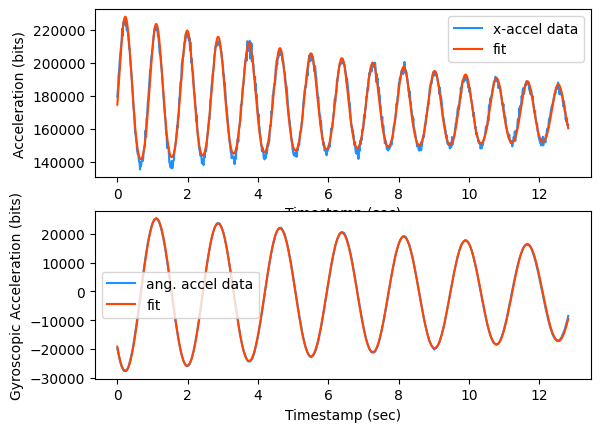

In [63]:
# plot the fits
accel_fit = x_accel_to_fit(timestamp, *popt0)
rad_accel_fit = theta_accel(timestamp, *popt1)
fig, ax = plt.subplots(2,1)

ax[0].plot(timestamp, g_m_s2*x_accel, c = 'dodgerblue', label = 'x-accel data')
ax[0].plot(timestamp, g_m_s2*accel_fit, c= 'orangered', label = 'fit')
ax[0].legend()
ax[0].set_xlabel('Timestamp (sec)')
ax[0].set_ylabel("Acceleration (bits)")

ax[1].plot(timestamp, z_gyro_bits, c = 'dodgerblue', label = 'ang. accel data')
ax[1].plot(timestamp, rad_accel_fit, c= 'orangered', label = 'fit')
ax[1].legend()
ax[1].set_xlabel('Timestamp (sec)')
ax[1].set_ylabel('Gyroscopic Acceleration (bits)')

In [64]:
# print and guess the fit parameters:
print('x acceleration:')
titles = ['x accel amplitude', 'damping coef', 'a', 'b', 'height']
units = ["bits", '/s', 'bits', 'bits', "bits"]
for i in range(len(titles)):
    print(titles[i], ': ', '{:.6g}'.format(popt0[i]) , '+/-', '{:.2g}'.format(pcov0[i][i]**0.5), units[i])
print('\nrad accel:')
titles2 = ['damping coef', 'ang freq', 'd', 'e', 'height']
units2 = ['/s', 'rad/s', 'bits', 'bits', 'bits']
for i in range(len(titles2)):
    print(titles2[i], ': ', '{:.6g}'.format(popt1[i]) , '+/-', '{:.2g}'.format(pcov1[i][i]**0.5), units2[i])

x acceleration:
x accel amplitude :  7031.4 +/- 46 bits
damping coef :  0.0750154 +/- 0.0011 /s
a :  1.36652 +/- 0.0075 bits
b :  -1.25526 +/- 0.0071 bits
height :  16325.4 +/- 37 bits

rad accel:
damping coef :  0.039739 +/- 0.00021 /s
ang freq :  3.57358 +/- 0.00022 rad/s
d :  -5129.06 +/- 11 bits
e :  -5623.48 +/- 10 bits
height :  -716.309 +/- 12 bits


In [65]:
# this cell is the back-of-envelope calculations Dr. Gaitan showed in our teams meeting 6/7
A = np.average(stat_accel)
L = g_m_s2/popt1[1]**2
max_gz_bits = popt1[1]*np.sqrt(popt1[2]**2+popt1[3]**2)
Axmin = popt0[4]+popt0[0]* np.cos(np.sqrt(popt0[2]**2+popt0[3]**2)) 
theta0 = np.arccos(1 - (abs(A) - abs(Axmin))/x_sensitivity) # effective starting angle
gz_max_rad_s = theta0*popt1[1]
z_sensitivity = np.degrees(gz_max_rad_s)/ (max_gz_bits)
datasheet_sensitivity = .004375

print('L: ', L, 'm')
print('Max Gz:', max_gz_bits, 'bits')
print('Ax min:', Axmin)
print('theta0:', theta0, 'rad,', np.degrees(theta0), 'deg')
print('Gz max:', gz_max_rad_s, 'rad/s, ', np.degrees(gz_max_rad_s), 'deg/s')
print('z-sensitivity: ', z_sensitivity, 'dps/bits')
print('datasheet: ', datasheet_sensitivity)
print('difference: ', (z_sensitivity- datasheet_sensitivity)/ (datasheet_sensitivity)*100, '%')

L:  0.7675990609838166 m
Max Gz: 27199.29995647935 bits
Ax min: 14350.1823555997
theta0: 0.5212417705383964 rad, 29.86495355777661 deg
Gz max: 1.8626968990962367 rad/s,  106.72467083032014 deg/s
z-sensitivity:  0.003923802119947446 dps/bits
datasheet:  0.004375
difference:  -10.31309440120125 %
